# The influence of healthcare spending on life expectancy
## An essay by Frank Kloosterman & Jochem Vlug
Studentnumbers: 4373863 & 4165993

![Healthcare](http://northcentralhealthdistrict.org/wp-content/uploads/2017/07/Coalition-banner.jpg)

## 1. Introduction

This is an interactive report which is written in Jupyter Notebook, using the markdown language and Python for programming the data. This report was made as a final assignment for the course Computer Engineering for Scientific Computing (EPA1333).
In this report, a data analysis has been conducted on the status of healthcare around the world. Using data from three datasets, we try to answer our research question:

*"What is the relation between life expectancy and healthcare spending?"*

This research question has multiple sub questions:
- What is the relation between out-of-pocket healthcare spending per household and the life expactancy?
- What is the relation between healthcare spending by government and life expectancy?
- What is the relation between GDP and personal healthcare spending?
- How do these variables and their relations evolve over the coming 10 years, based on 15 years of data?

Overview of different chapters:
- Chapter 1: Introduction
- Chapter 2: Preperation of data transformation
- Chapter 3: Transforming the data and overview of the transformed data from 2000 till 2015
- Chapter 4: Relations between variables
- Chapter 5: Prediction of variables and their relations
- Chapter 6: GeoData
- Chapter 7: Conclusion

# 2. Preperation of data transformation
## 2.1 Packages

To be able read the datasets, apply mathematical operations to the data, plot graphs and execute many more operations we use libraries made by the community using packages. First, we import these packages using the block below. It is necessary to run this script for the functions to work.

In [1]:
import pandas as pd # Pandas, needed for data frames.
import numpy as np # NumPy, for math operations and arrays.
import matplotlib.pyplot as plt #matplotlib, for making plots.
import missingno as msno # Missingno, a usefull library for checking missing values.
import pdb # Pythondebugger, native debugger of python.
import seaborn as sns #Seaborn for plotting scatter plots with regression lines
import geopandas as gpd #This package makes it possible to plot world maps
import geoplot.crs as gcrs #Dependencies for the functioning of gpd
import geoplot as gplt
%matplotlib inline
# A line which causes plots to  make graphs directly below codeblocks after running them.

## 2.2 Datasets
The data used for our research consists of three datasets, which are loaded in the block below. These datasets are:
- Sustainable Development Goals, The World Bank. 2017. datacatalog.worldbank.org

This dataset has a very large amount of data which are related to the UN SDG's. In this dataset, we use the data that is related to the simple economical status of a country to get an idea of the welfare status of the country.
- Life Expectancy, Global Health Observatory - World Health Organisation (WHO). 2017. who.int/gho

This is a section of a much larger dataset from the WHO, gathered by using the only query tool on the WHO website. In this dataset, the average life expectancy of citizens in a country are gathered.
- Average Household Pocket Money, The World Bank. 2017. data.worldbank.org

This dataset is a collection of the average amount of "household out of pocket money" spent on healthcare. This means the amount of money an average citizen spends on healthcare from their own finances. This excludes costs for healthcare insurences.
- Capital Health Expenditure, Global Health Observatory - World Health Organisation (WHO). 2017. who.int/gho

To get an idea of the healthcare governance per country, this dataset gives an average of money spent on healthcare compare to the total amount of money spent by the government (so it is a percentage).

In [23]:
# Sustainable Development Goals
SDG = pd.read_csv("https://github.com/Jochem285/EPA1333FA/raw/master/Data/SustainableDevelopmentGoals.csv")
# Life Expectancy
life_exp = pd.read_csv("https://github.com/Jochem285/EPA1333FA/raw/master/Data/LifeExpectancy.csv")
# Household pocket money. Second row is empty, so we skip it.
house_money = pd.read_excel("https://github.com/Jochem285/EPA1333FA/raw/master/Data/HouseholdPocketMoney.xlsx",skiprows=[1],index_col=0)
# Capital health expenditure. Second row is empty, so we skip it.
cap_exp = pd.read_excel("https://github.com/Jochem285/EPA1333FA/raw/master/Data/CapitalHealthExpenditure.xlsx",skiprows=[1],index_col=0)

## 2.3 Search the Data
To quickly get a glance at the data, we first make a function which can search the data using a keyword to search for. 

In [3]:
#Search world_bank database for keyphrase
def searchData(myInput):
    variableList = []
    for sentence in list(SDG["Indicator Name"].values):
        newSentence = np.array(sentence.split(" "))
        for words in (newSentence):
            if words.lower() == myInput.lower(): 
                variableList += [sentence]

    variableList = pd.unique(variableList)
    return variableList
searchData("") #insert search input here.

array(['Women making their own informed decisions regarding sexual relations, contraceptive use and reproductive health care  (% of women age 15-49)'],
      dtype=object)

## 2.4 Overview of the Data
To get an overview of the data and the availability of data in the datasets, we plot a matrix which shows the amount of (missing) data. We use MissingNo to make this matrix.

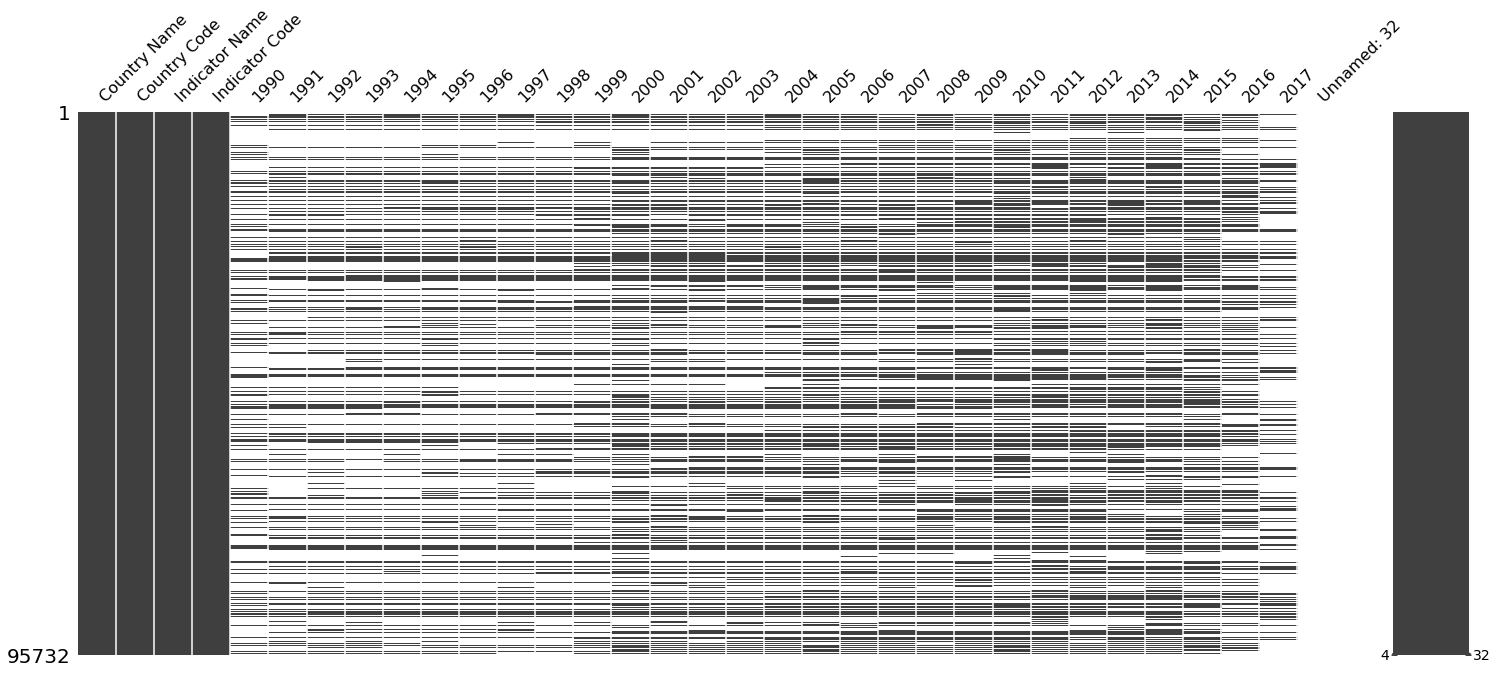

In [4]:
#First summarise status of data by making a NaN matrix.
msno.matrix(SDG.sample(len(SDG)))
#life_exp["Life "] = life_exp["Life Expectancy"] TODO fix colomn name
#msno.matrix(life_exp.sample(len(life_exp)))
#msno.matrix(house_money.sample(len(house_money)))
#msno.matrix(cap_exp.sample(len(cap_exp)))

# 3 Transforming the Data
## 3.1 Finding poorest and richest countries
To get an overview, we use the 20 richest and poorest countries in the world to see if there is a relation between factors of healthcare related data. This might not entail a complete causal relation between factors, but can be used as a proper indication for certain correlations between the data.

To start with the data transforming we take the data of the SDGs and take the Country name, GDP of 2016 and GDP of 2017 of the data with the indicator 'GDP per capita, PPP (contstant 2011 international)'. We bind these columns into one dataframe, GDP_1617. Since the matrix above shows that 2017 misses a lot of data compared to earlier years, we check below whether the information about the GDP of 2016 and 2017 differ significantly.

The graph shows that the years only differ slightly, so we use the most up-to-date set: 2017.

Halfway we mask regions of china and North America, since we would like to compare complete countries rather than regions or continents. We also mask San Marino, since there is almost no data available about the country and select the countries with the highest and lowest GDP. Ofcourse, in the model process we masked the regions, continents and San Marino after we found the highest and lowest countries. These countries, without the GDP, are the output and these countries will be used in further analysis. 




In [5]:
#This section makes a Top 20 list of richest and poorest countries based on GDP per capita, PPP.
#We will use these countries in further analysis

#Define the countries and their GDP's to determine Top richest and poorest.
countries = SDG[SDG["Indicator Name"]== 'GDP per capita, PPP (constant 2011 international $)']["Country Name"]
GDP_2016 = SDG[SDG["Indicator Name"]== 'GDP per capita, PPP (constant 2011 international $)']["2016"]
GDP_2017 = SDG[SDG["Indicator Name"]== 'GDP per capita, PPP (constant 2011 international $)']["2017"]

#Combine the country names with GDP's
GDP_1617 = countries.to_frame().join(GDP_2017.to_frame()).join(GDP_2016.to_frame())

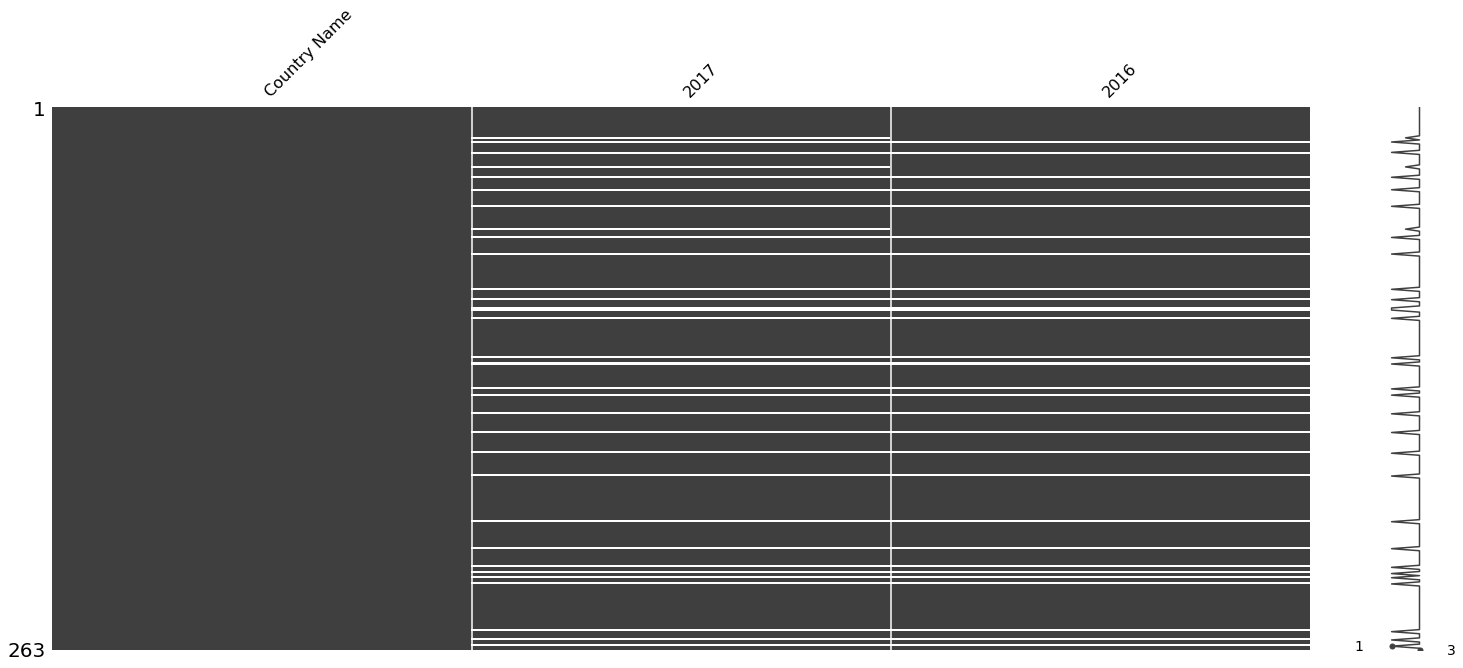

In [6]:
msno.matrix(GDP_1617.sample(len(GDP_1617)))

In [85]:
#Mask the entries in the top 20's of the list which are actually not countries.
GDP_1617 = GDP_1617.mask(GDP_1617["Country Name"]=="Macao SAR, China")
GDP_1617 = GDP_1617.mask(GDP_1617["Country Name"]=="Hong Kong SAR, China")
GDP_1617 = GDP_1617.mask(GDP_1617["Country Name"]=="North America")
GDP_1617 = GDP_1617.mask(GDP_1617["Country Name"]=="High income")
#Masked small states as well, since there is almost no data available
GDP_1617 = GDP_1617.mask(GDP_1617["Country Name"]=="San Marino")
GDP_1617 = GDP_1617.mask(GDP_1617["Country Name"]=="Brunei Darussalam")

#Define the top20's
lowest_20 = GDP_1617.sort_values("2017")[0:20]
highest_20 = GDP_1617.sort_values("2017", ascending=False)[0:20]

lowest_countries = lowest_20["Country Name"]
highest_countries = highest_20["Country Name"]
    
#Concate the highest and lowest together.
newCountries = pd.concat([lowest_countries, highest_countries])

#Set countries in alphabetic order. 
newCountries = newCountries.sort_values(ascending = True)

#To prevent errors, debug when the list does not contain 40 countries.
if len(newCountries) < 40:
    newCountries = str("Something went wrong.")
else:
    newCountries = list(newCountries.values)

## 3.2 Transforming and format differnet datasets
In the cells below are the countries, which were output of the cell above, put in the other dataframe about household expenses on healthcare. Only three countries had different names in the  datasets, so these names are manually adjusted in order to match. After the adjustments, the countries are filled in the datasets and both are given the same format to easily being match. 
### 3.2.1 Out-of-pocket money spend on healthcare

In [33]:
#Match the countries of the SDG dataset with the countries of the out-of-pocket  dataset
household_countries = newCountries
household_countries[11]="DRC"
household_countries[14]="Gambia"
household_countries[39]="United States of America"

household_data = house_money.loc[household_countries]
#remove ugly columns
household_data = household_data.drop(["Indicators","Unnamed: 2"], axis = 1).T
household_data.head()

Countries,Afghanistan,Australia,Austria,Bahrain,Belgium,Burkina Faso,Burundi,Canada,Central African Republic,Chad,...,Rwanda,Saudi Arabia,Sierra Leone,Singapore,Sweden,Switzerland,Togo,Uganda,United Arab Emirates,United States of America
2000,NaN,342.762120,403.404231,106.291816,NaN,3.172817,4.197771,331.877442,4.832313,5.764260,...,2.450067,70.967918,8.082079,395.402906,314.297672,1167.607637,7.404805,7.096708,172.651978,705.592737
2001,NaN,318.475054,421.051522,110.685341,NaN,3.293572,3.719912,327.185044,4.694655,6.886266,...,2.196349,69.546957,14.878924,392.871779,371.557688,1191.626889,7.271176,6.967621,116.415650,724.132942
2002,13.873145,351.338568,462.750230,114.785111,NaN,3.335261,3.438550,342.170373,4.943164,11.756481,...,2.051486,67.864775,16.320056,399.372034,417.052476,1322.578344,8.077396,7.085112,238.619640,762.813137
2003,15.054136,429.094207,582.576100,118.434858,577.214388,3.922435,3.103091,389.144923,5.939127,8.647954,...,2.922966,68.332341,17.081300,401.652125,513.431022,1581.824433,9.668791,6.714104,241.454572,812.505363
2004,17.689163,529.975019,660.604845,121.465464,607.799246,5.360952,3.357498,445.396005,6.549299,14.436606,...,4.292764,72.461491,16.521031,422.971015,588.436976,1774.730135,10.195482,10.706004,270.726932,849.386662


### 3.2.2 Life expectancy

In [36]:
#Match the countries of the SDG dataset with the countries of the life expectancy dataset
life_exp_countries = newCountries
life_exp_countries[11] ="Congo"
life_exp_countries[14]="Gambia"
life_exp_countries[39]="United States"

life_exp_data = life_exp.loc[life_exp["Entity"].isin(life_exp_countries)]

In [37]:
#Transform the life expectancy data into the same format as household data
#Create the dataframe by starting with the first
LE_total = pd.DataFrame()
for Country in life_exp_data["Entity"].unique():
    LE_country = life_exp_data[life_exp_data["Entity"]==Country]
    years = LE_country["Year"].values
    LE_country = LE_country.set_index(years)
    LE_country = LE_country.iloc[:,3:]
    LE_country.columns = [Country]
    if LE_total.empty:
        LE_total = LE_country
    else: 
        LE_total = pd.merge(LE_total, LE_country, left_index=True, right_index=True)    

In [41]:
#Rename to earlier variable with the same years as in household dataset (from 2000 onwards)
life_exp_data = LE_total[50:]
life_exp_data.head()

,Afghanistan,Australia,Austria,Bahrain,Belgium,Burkina Faso,Burundi,Canada,Central African Republic,Chad,...,Rwanda,Saudi Arabia,Sierra Leone,Singapore,Sweden,Switzerland,Togo,Uganda,United Arab Emirates,United States
2000,55.481998,79.589996,78.238998,74.440002,77.866997,50.488998,51.544998,79.113998,43.937000,47.592999,...,48.415001,72.440002,38.702000,78.338997,79.724998,79.858002,53.488998,47.077000,74.238998,76.815002
2001,56.043999,79.885002,78.517998,74.635002,78.070999,50.893002,51.778999,79.337997,43.755001,47.603001,...,49.792999,72.651001,39.660000,78.664001,79.893997,80.117996,53.550999,48.119999,74.487000,76.962997
2002,56.637001,80.175003,78.791000,74.821999,78.285004,51.383999,51.977001,79.565002,43.717999,47.638000,...,50.970001,72.820000,40.660000,79.028999,80.061996,80.377998,53.707001,49.242001,74.730003,77.121002
2003,57.250000,80.452003,79.058998,74.999001,78.509003,51.956001,52.189999,79.791000,43.827000,47.716000,...,52.268002,72.947998,41.668999,79.419998,80.235001,80.640999,53.935001,50.394001,74.968002,77.292000
2004,57.875000,80.712997,79.318001,75.167000,78.739998,52.602001,52.437000,80.013000,44.080002,47.848000,...,53.755001,73.041000,42.660000,79.824997,80.413002,80.903999,54.230000,51.537998,75.199997,77.474998


### 3.2.3 GDP per country

In [77]:
#Modify and select only the data needed for analysis
GDP = SDG[SDG["Indicator Name"]== 'GDP per capita, PPP (constant 2011 international $)']
GDP_data = GDP.set_index(GDP["Country Name"])
GDP_data.drop(GDP_data.iloc[:,0:14], inplace = True, axis = 1)
GDPCountries = newCountries
GDPCountries[14]= "Gambia, The"
GDPCountries[11]= "Congo, Dem. Rep."
GDP_data.drop(columns ="Unnamed: 32")
GDP_data = GDP_data.loc[newCountries].iloc[:,0:18].T
GDP_data.head()

Country Name,Afghanistan,Australia,Austria,Bahrain,Belgium,Burkina Faso,Burundi,Canada,Central African Republic,Chad,...,Rwanda,Saudi Arabia,Sierra Leone,Singapore,Sweden,Switzerland,Togo,Uganda,United Arab Emirates,United States
2000,NaN,35377.729552,38844.404714,44942.369023,37188.643693,1075.395337,754.096280,37431.916978,813.041558,993.182982,...,792.923578,43071.449832,912.742558,51706.434823,36854.868762,50775.976339,1276.990341,1049.778625,102634.924268,45986.052710
2001,NaN,35578.642071,39186.337002,43887.071192,37361.718438,1114.202253,751.388913,37712.128235,832.227925,1067.947758,...,828.835614,41472.853344,823.286273,49851.079273,37330.704974,51117.887441,1221.466431,1067.961203,98716.970421,45977.549991
2002,1063.635574,36553.964614,39638.026874,43147.496378,37856.864713,1129.740538,763.177201,38500.317077,845.684657,1115.037497,...,915.447814,39194.772390,994.992436,51478.685107,37980.980052,50815.153156,1178.008315,1122.249626,95894.914426,46366.577974
2003,1099.194507,37183.684574,39816.774123,43187.499185,37990.713309,1183.094880,730.902951,38805.671114,785.159427,1231.115101,...,920.073174,42344.410918,1036.965340,54560.544506,38742.680261,50459.502906,1204.282612,1154.200711,97790.177403,47260.041937
2004,1062.249360,38225.693714,40652.810702,43355.305653,39201.527156,1200.417062,741.766252,39604.354861,817.170646,1584.673150,...,973.116345,44390.957626,1056.584409,59027.012627,40257.923532,51505.092367,1197.983399,1190.574441,98076.533161,48597.337362


### 3.2.4 Capital health expenditure per country
While processing the capital health expenditure it became clear that there isn't a lot of data available for the poorest and richest countries. There are 13 countries, which had no available data, which are excluded from the countrylist. 


Afterwards the matrix was drawn to find out which year had the most data, this was the year 2013. We will use this year for further analysis. 

In [112]:
#Match the countries of the SDG dataset with the countries of the life expectancy dataset
cap_exp_countries = newCountries
cap_exp_countries[11] ="Congo"
cap_exp_countries[14]="Gambia"
cap_exp_countries[39]="United States of America"

cap_exp_data = cap_exp.reindex(cap_exp_countries) #Fit country names to df
cap_exp_data = cap_exp_data.dropna(axis=0,thresh=2) #Drop empty rows
cap_exp_data.head()

,Indicators,Unnamed: 2,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Countries,,,,,,,,,,,,,,,,,,
Afghanistan,Capital health expenditure,in current US$ per capita,NaN,NaN,0.487005,1.117540,0.166191,0.316349,0.977841,2.420919,0.699484,0.315256,0.911098,0.633257,0.902433,1.200907,1.039354,1.269971
Australia,Capital health expenditure,in current US$ per capita,100.061941,96.006561,110.934411,118.826335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,367.356094,NaN
Austria,Capital health expenditure,in current US$ per capita,152.233575,137.630584,157.233451,201.178543,226.629029,240.260440,235.123065,287.502880,327.109732,316.134108,324.435043,362.494259,374.124189,377.064550,389.642022,323.430407
Burkina Faso,Capital health expenditure,in current US$ per capita,3.950715,3.803175,5.010302,6.889041,6.342525,9.892169,6.308134,3.530185,8.781058,9.342297,7.349035,2.159977,4.126805,2.812697,2.979952,1.321941
Burundi,Capital health expenditure,in current US$ per capita,NaN,NaN,NaN,0.029093,0.080939,0.757393,0.004324,0.324195,0.511787,0.225892,0.987036,1.132533,0.017852,2.116864,2.948462,0.179264


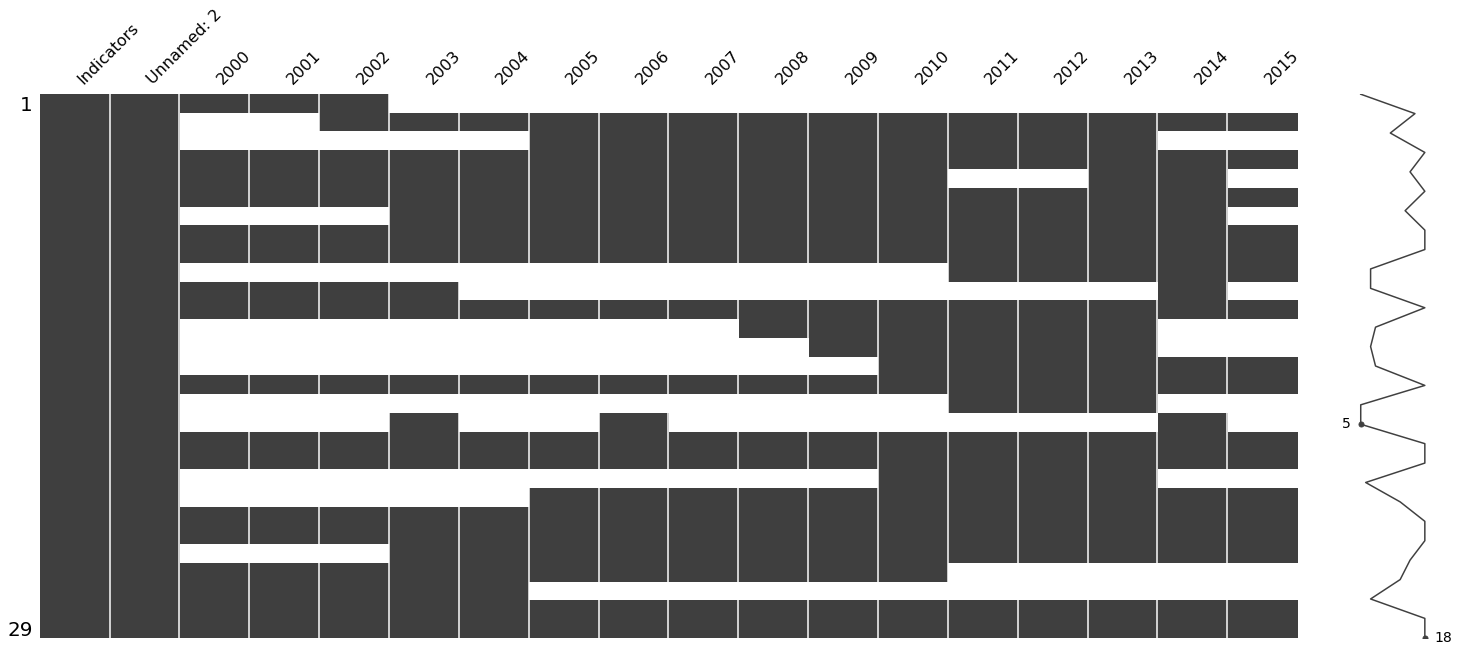

In [113]:
#Show the data in order to explore in what most recent year, most countries are available. 
msno.matrix(cap_exp_data.sample(len(cap_exp_data)))
#2013 is most recent with most available data. 

# 4. Relations between variables
## 4.1 Relation between out-of-pocket money spent on healthcare and life expectancy
Since the latest data available in the databases is the data of 2015, we will examine the relation between the average out-of-pocket money spend on healthcare per household and the life expectancy per country in this year. The out-of-pocket money spend on healthcare will be in US dollars. 

Australia's latest out-of-pocket money spent on healthcare per household is from 2014, so we will assume that it was the same in 2015. 

In [114]:
#Prepare the data of out-of-pocket money spend on healthcare per household over 2015
household_15 = household_data.loc["2015"]
household_15["Australia"] =household_data.loc["2014"]["Australia"]

#Select the data of life expectancy over 2015
life_exp_15 = life_exp_data.loc[2015]

Now we create a scatter plot of the 2015 data to see if the data is scattered, and to which extent.

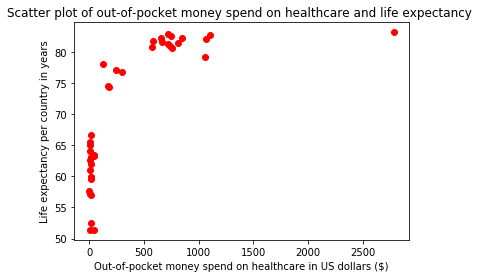

In [115]:
plt.scatter(household_15, life_exp_15, color = "red")
plt.xlabel("Out-of-pocket money spend on healthcare in US dollars ($)")
plt.ylabel("Life expectancy per country in years")
plt.title("Scatter plot of out-of-pocket money spend on healthcare and life expectancy ")
plt.show()

Using the created scatter plot of the 2015 data we plot a regression line, the data looks logarithmic. 

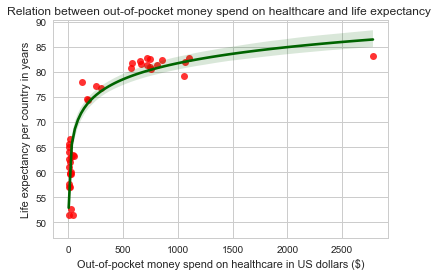

In [116]:
sns.set(style = "whitegrid")
sns.regplot(x=household_15,y=life_exp_15, logx = True, truncate = True, 
            scatter_kws={"color":"red"}, line_kws={ "color":"darkgreen"})
plt.xlabel("Out-of-pocket money spend on healthcare in US dollars ($)")
plt.ylabel("Life expectancy per country in years")
plt.title("Relation between out-of-pocket money spend on healthcare and life expectancy ")
plt.show()

When using a logarithmic y-scale, the correlation between life expectancy and money spend is more clear to see.

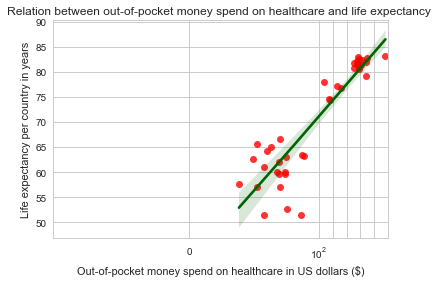

In [117]:
sns.set(style = "whitegrid")
sns.regplot(x=household_15,y=life_exp_15, logx = True, truncate = True, 
            scatter_kws={"color":"red"}, line_kws={ "color":"darkgreen"})
plt.xlabel("Out-of-pocket money spend on healthcare in US dollars ($)")
plt.ylabel("Life expectancy per country in years")
plt.xscale("symlog")
plt.xticks([0,100,200,400,800,1600,3200])
plt.title("Relation between out-of-pocket money spend on healthcare and life expectancy ")
plt.show()
#TODO: Fix somehow that the left part of the graph behaves.

## 4.2 Relation between capital expensure on healthcare and life expectancy

In [118]:
#Prepare the data of the capital health expenditure per capita.
#Use the year 2013, since most data is available here (see preperation of the data).
cap_exp_13 = cap_exp_data["2013"].dropna()
cap_exp_13_countries = cap_exp_13.index

#Select the data of life expectanct of 2013 and the 23 countries which have data about capital.
life_exp_13 = life_exp_data.loc[2013]
cap_exp_13_countries = list(cap_exp_13.index)
cap_exp_13_countries[8]="Congo"
cap_exp_13_countries[-1]="United States"

life_exp_13 = life_exp_13[cap_exp_13_countries]

We first plot a scatterplot of the data again to scan the data and see what kind of relation it can be.

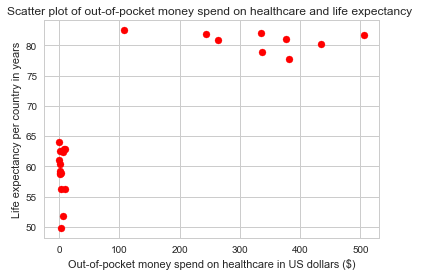

In [119]:
plt.scatter(cap_exp_13, life_exp_13, color = "red")
plt.xlabel("Out-of-pocket money spend on healthcare in US dollars ($)")
plt.ylabel("Life expectancy per country in years")
plt.title("Scatter plot of out-of-pocket money spend on healthcare and life expectancy ")
plt.show()

Just like the relation between the out of pocket money spend on healthcare and life expectancy, looks like this correlation is logarithmical as well. 

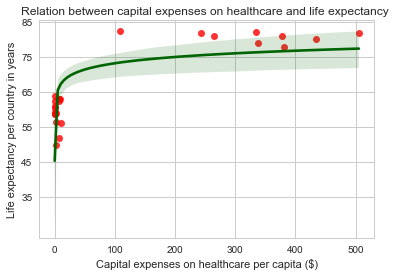

In [120]:
sns.set(style = "whitegrid")
sns.regplot(x=cap_exp_13,y=life_exp_13,logx = True, truncate = True, 
            scatter_kws={"color":"red"}, line_kws={ "color":"darkgreen"})
plt.xlabel("Capital expenses on healthcare per capita ($)")
plt.yticks(np.arange(35,90,10))
plt.ylabel("Life expectancy per country in years")
plt.title("Relation between capital expenses on healthcare and life expectancy ")
plt.show()

When plotting in a logarithmic scale, we see the correlation is not as logarithmic as the previous graph.

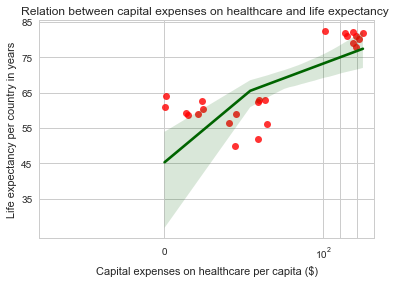

In [122]:
sns.set(style = "whitegrid")
sns.regplot(x=cap_exp_13,y=life_exp_13,logx = True, truncate = True, 
            scatter_kws={"color":"red"}, line_kws={ "color":"darkgreen"})
plt.xlabel("Capital expenses on healthcare per capita ($)")
plt.yticks(np.arange(35,90,10))
plt.ylabel("Life expectancy per country in years")
plt.title("Relation between capital expenses on healthcare and life expectancy ")
plt.xscale("symlog")
plt.xticks([0,100,200,400,800])
plt.show()

## 4.3 Relation between GDP and life expectancy
Since the database provided the most recent data about life expectancy, we will use the GDP data of 2015 as well. 

In [123]:
GDP_15 = GDP_data.loc["2015"]

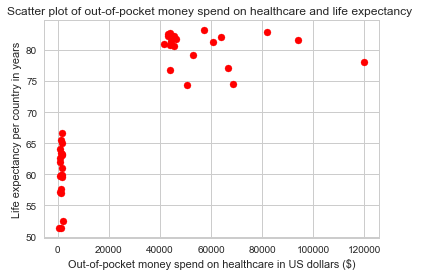

In [124]:
plt.scatter(GDP_15, life_exp_15, color = "red")
plt.xlabel("Out-of-pocket money spend on healthcare in US dollars ($)")
plt.ylabel("Life expectancy per country in years")
plt.title("Scatter plot of out-of-pocket money spend on healthcare and life expectancy ")
plt.show()

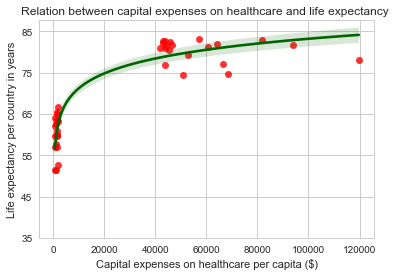

In [125]:
sns.regplot(x=GDP_15,y=life_exp_15,logx = True, truncate = True, 
            scatter_kws={"color":"red"}, line_kws={ "color":"darkgreen"})
plt.xlabel("Capital expenses on healthcare per capita ($)")
plt.yticks(np.arange(35,90,10))
plt.ylabel("Life expectancy per country in years")
plt.title("Relation between capital expenses on healthcare and life expectancy ")
plt.show()

When plotting the correlation curve on a logarithmic scale, a clear correlation is shown.

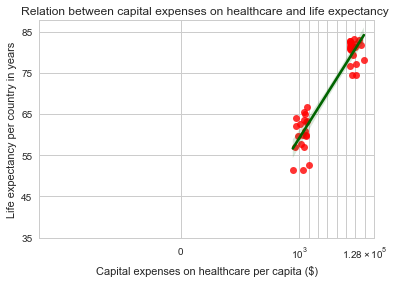

In [126]:
sns.regplot(x=GDP_15,y=life_exp_15,logx = True, truncate = True, 
            scatter_kws={"color":"red"}, line_kws={ "color":"darkgreen"})
plt.xlabel("Capital expenses on healthcare per capita ($)")
plt.yticks(np.arange(35,90,10))
plt.ylabel("Life expectancy per country in years")
plt.title("Relation between capital expenses on healthcare and life expectancy ")
plt.xscale("symlog")
plt.xticks([0,1000,2000,4000,8000,16000,32000,64000,128000,256000])
plt.show()

# 5. Prediction of the variables
## 5.1 Prediction of household expenses and Life expectancy
Based on the information of 2000 till 2015 a polyval can be fitted to the data and future household expenses on healthcare and life expectancy can be predicted.

In [127]:
#Predicting the life expectancy based on the last 15 years. 
years = np.arange(2000,2016,1)
HH_pred = pd.DataFrame()

#Modify the data in order to withhold the prediction to crash, by replacing missing numbers with closest year. 
household_pred_data = household_data
household_pred_data.iloc[0]["Afghanistan"]=household_pred_data.iloc[2]["Afghanistan"]
household_pred_data.iloc[1]["Afghanistan"]=household_pred_data.iloc[2]["Afghanistan"]
household_pred_data.iloc[15]["Australia"]=household_pred_data.iloc[14]["Australia"]
household_pred_data.iloc[0]["Belgium"]=household_pred_data.iloc[3]["Belgium"]
household_pred_data.iloc[1]["Belgium"]=household_pred_data.iloc[3]["Belgium"]
household_pred_data.iloc[2]["Belgium"]=household_pred_data.iloc[3]["Belgium"]

for Country in household_data.columns:
    new_country = household_pred_data[Country]
    coeff_poly = np.polyfit(years, new_country,1)
    for i in np.arange(1,11,1):
        pred_HH = np.polyval(coeff_poly, years[-1]+i)
        new_country = new_country.append(pd.Series([pred_HH], index=[years[-1]+i], name=Country))
    HH_pred[Country]= new_country

    
HH_pred.head()
#plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol = 2)
#plt.show()

,Afghanistan,Australia,Austria,Bahrain,Belgium,Burkina Faso,Burundi,Canada,Central African Republic,Chad,...,Rwanda,Saudi Arabia,Sierra Leone,Singapore,Sweden,Switzerland,Togo,Uganda,United Arab Emirates,United States of America
2000,13.873145,342.762120,403.404231,106.291816,577.214388,3.172817,4.197771,331.877442,4.832313,5.764260,...,2.450067,70.967918,8.082079,395.402906,314.297672,1167.607637,7.404805,7.096708,172.651978,705.592737
2001,13.873145,318.475054,421.051522,110.685341,577.214388,3.293572,3.719912,327.185044,4.694655,6.886266,...,2.196349,69.546957,14.878924,392.871779,371.557688,1191.626889,7.271176,6.967621,116.415650,724.132942
2002,13.873145,351.338568,462.750230,114.785111,577.214388,3.335261,3.438550,342.170373,4.943164,11.756481,...,2.051486,67.864775,16.320056,399.372034,417.052476,1322.578344,8.077396,7.085112,238.619640,762.813137
2003,15.054136,429.094207,582.576100,118.434858,577.214388,3.922435,3.103091,389.144923,5.939127,8.647954,...,2.922966,68.332341,17.081300,401.652125,513.431022,1581.824433,9.668791,6.714104,241.454572,812.505363
2004,17.689163,529.975019,660.604845,121.465464,607.799246,5.360952,3.357498,445.396005,6.549299,14.436606,...,4.292764,72.461491,16.521031,422.971015,588.436976,1774.730135,10.195482,10.706004,270.726932,849.386662


## 5.2 Prediction of the life expectancy

In [128]:
#Predicting the life expectancy based on the last 15 years. 
years = np.arange(2000,2016,1)
LE_pred = pd.DataFrame()
for Country in life_exp_data.columns:
    new_country = life_exp_data[Country]
    coeff_poly = np.polyfit(years, new_country,2)
    for i in np.arange(1,11,1):
        pred_LE = np.polyval(coeff_poly, years[-1]+i)
        new_country = new_country.append(pd.Series([pred_LE], index=[years[-1]+i], name=Country))
    LE_pred[Country]= new_country

    
LE_pred.head()

#LE_pred['Netherlands']
#Nederland komt redelijk overeen met deze verwachting: https://www.statista.com/statistics/523696/netherlands-life-expectancy-at-birth-forecast-2015-2060/


,Afghanistan,Australia,Austria,Bahrain,Belgium,Burkina Faso,Burundi,Canada,Central African Republic,Chad,...,Rwanda,Saudi Arabia,Sierra Leone,Singapore,Sweden,Switzerland,Togo,Uganda,United Arab Emirates,United States
2000,55.481998,79.589996,78.238998,74.440002,77.866997,50.488998,51.544998,79.113998,43.937000,47.592999,...,48.415001,72.440002,38.702000,78.338997,79.724998,79.858002,53.488998,47.077000,74.238998,76.815002
2001,56.043999,79.885002,78.517998,74.635002,78.070999,50.893002,51.778999,79.337997,43.755001,47.603001,...,49.792999,72.651001,39.660000,78.664001,79.893997,80.117996,53.550999,48.119999,74.487000,76.962997
2002,56.637001,80.175003,78.791000,74.821999,78.285004,51.383999,51.977001,79.565002,43.717999,47.638000,...,50.970001,72.820000,40.660000,79.028999,80.061996,80.377998,53.707001,49.242001,74.730003,77.121002
2003,57.250000,80.452003,79.058998,74.999001,78.509003,51.956001,52.189999,79.791000,43.827000,47.716000,...,52.268002,72.947998,41.668999,79.419998,80.235001,80.640999,53.935001,50.394001,74.968002,77.292000
2004,57.875000,80.712997,79.318001,75.167000,78.739998,52.602001,52.437000,80.013000,44.080002,47.848000,...,53.755001,73.041000,42.660000,79.824997,80.413002,80.903999,54.230000,51.537998,75.199997,77.474998


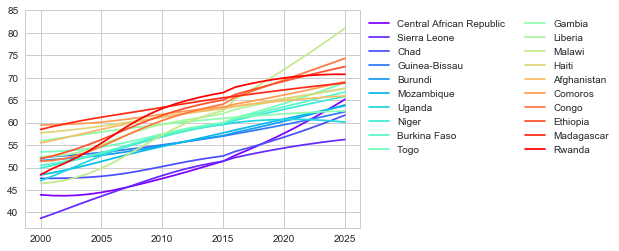

In [129]:
#See how the lowest half of the is predicted, since this is most interesting
lowest_LE_pred = LE_pred.T[life_exp_data.T[2000]<70].T
lowest_LE_pred.sort_values(by = 2015, axis=1).plot(linestyle = ("-"),cmap=plt.cm.get_cmap('rainbow'))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol = 2)
plt.yticks(np.arange(40,90,5))
plt.show()

## 5.3 Checking if relations of 2015 are same as predicted model of 2025
First again plot a scatter to see if it is similiar distributed. 

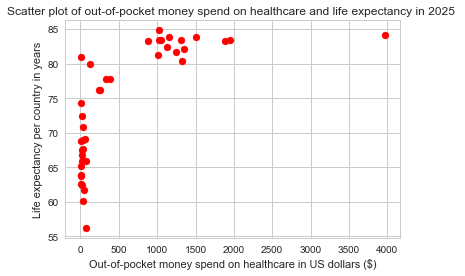

In [130]:
plt.scatter(HH_pred.loc[2025], LE_pred.loc[2025], color = "red")
plt.xlabel("Out-of-pocket money spend on healthcare in US dollars ($)")
plt.ylabel("Life expectancy per country in years")
plt.title("Scatter plot of out-of-pocket money spend on healthcare and life expectancy in 2025 ")
plt.show()

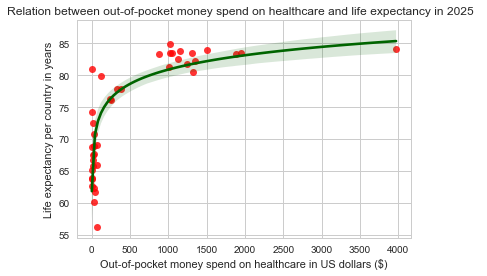

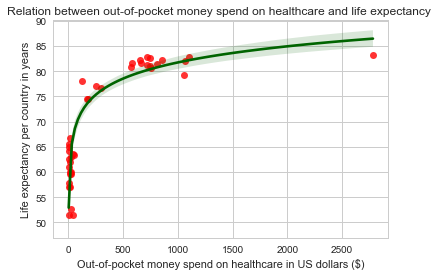

In [131]:
sns.set(style = "whitegrid")
sns.regplot(x=HH_pred.loc[2025],y=LE_pred.loc[2025],logx = True, truncate = True, 
            scatter_kws={"color":"red"}, line_kws={ "color":"darkgreen"})
plt.xlabel("Out-of-pocket money spend on healthcare in US dollars ($)")
plt.ylabel("Life expectancy per country in years")
plt.title("Relation between out-of-pocket money spend on healthcare and life expectancy in 2025  ")
plt.show()

sns.set(style = "whitegrid")
sns.regplot(x=household_15,y=life_exp_15, logx = True, truncate = True, 
            scatter_kws={"color":"red"}, line_kws={ "color":"darkgreen"})
plt.xlabel("Out-of-pocket money spend on healthcare in US dollars ($)")
plt.ylabel("Life expectancy per country in years")
plt.title("Relation between out-of-pocket money spend on healthcare and life expectancy ")
plt.show()

Changing the scale of the x-axis shows a clear logarithmic correlation.

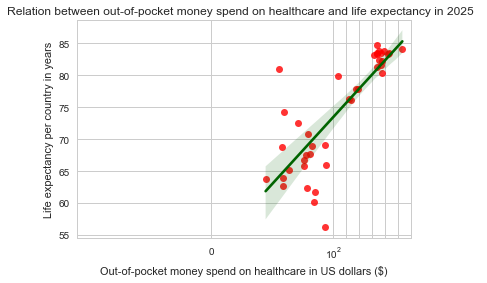

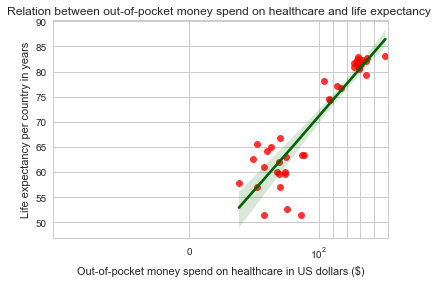

In [132]:
sns.set(style = "whitegrid")
sns.regplot(x=HH_pred.loc[2025],y=LE_pred.loc[2025],logx = True, truncate = True, 
            scatter_kws={"color":"red"}, line_kws={ "color":"darkgreen"})
plt.xlabel("Out-of-pocket money spend on healthcare in US dollars ($)")
plt.ylabel("Life expectancy per country in years")
plt.title("Relation between out-of-pocket money spend on healthcare and life expectancy in 2025  ")
plt.xscale("symlog")
plt.xticks([0,100,200,400,800,1600,3200,6400])
plt.show()

sns.set(style = "whitegrid")
sns.regplot(x=household_15,y=life_exp_15, logx = True, truncate = True, 
            scatter_kws={"color":"red"}, line_kws={ "color":"darkgreen"})
plt.xlabel("Out-of-pocket money spend on healthcare in US dollars ($)")
plt.ylabel("Life expectancy per country in years")
plt.title("Relation between out-of-pocket money spend on healthcare and life expectancy ")
plt.xscale("symlog")
plt.xticks([0,100,200,400,800,1600,3200])
plt.show()

# 6. Geolocation data
To get a better "feeling" of the data, we use our findings and map them to the world map. In this chapter, some of our most prominent conclusive data will be plotted on a worldmap.
